In [ ]:
  # # Import and install necessary libraries
# !pip install torchsummary
# !pip install imblearn
# !pip install torch-geometric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm, SAGEConv, global_mean_pool
from torch_geometric.utils import to_networkx, degree, subgraph, k_hop_subgraph, is_undirected, to_undirected
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
from torchsummary import summary

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score
from sklearn.utils import compute_class_weight, resample
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx
from datetime import datetime
import seaborn as sns


import zipfile
import random
from google.colab import drive
import os


# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [ ]:
# Setting seed for reproducibility

def set_seed(seed=42):
    # Python built-in RNG
    random.seed(seed)

    # NumPy RNG
    np.random.seed(seed)

    # PyTorch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

    # For deterministic behavior (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)


set_seed(42)

In [ ]:
drive.mount('/content/drive')
path='/content/drive/My Drive/DLSS/twitch_gamers.zip'

Mounted at /content/drive


In [ ]:
# Where to extract the files
extract_to = '/content/extracted_data'

# Create the directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [ ]:
# Loading the feature/edge data
features_df = pd.read_csv("extracted_data/large_twitch_features.csv")
edges_df = pd.read_csv("extracted_data/large_twitch_edges.csv")

print("Features:")
print(features_df.head())
print("Edges:")
print(edges_df.head())

print(features_df.dtypes)

Features:
    views  mature  life_time  created_at  updated_at  numeric_id  \
0    7879       1        969  2016-02-16  2018-10-12           0   
1     500       0       2699  2011-05-19  2018-10-08           1   
2  382502       1       3149  2010-02-27  2018-10-12           2   
3     386       0       1344  2015-01-26  2018-10-01           3   
4    2486       0       1784  2013-11-22  2018-10-11           4   

   dead_account language  affiliate  
0             0       EN          1  
1             0       EN          0  
2             0       EN          1  
3             0       EN          0  
4             0       EN          0  
Edges:
   numeric_id_1  numeric_id_2
0         98343        141493
1         98343         58736
2         98343        140703
3         98343        151401
4         98343        157118
views            int64
mature           int64
life_time        int64
created_at      object
updated_at      object
numeric_id       int64
dead_account     int64
langu

In [ ]:
# Preparing Data

# Ensure datetime parsing
features_df['created_at'] = pd.to_datetime(features_df['created_at'], errors='coerce')
features_df['updated_at'] = pd.to_datetime(features_df['updated_at'], errors='coerce')

# Convert to UNIX timestamp (in seconds)
features_df['created_at'] = features_df['created_at'].astype('int64') // 1_000_000_000
features_df['updated_at'] = features_df['updated_at'].astype('int64') // 1_000_000_000

In [ ]:
categorical_features = ["affiliate", "dead_account", "language", "mature"]
continuous_features = ["life_time", "views", "created_at", "updated_at"]

Histograms for continuous features



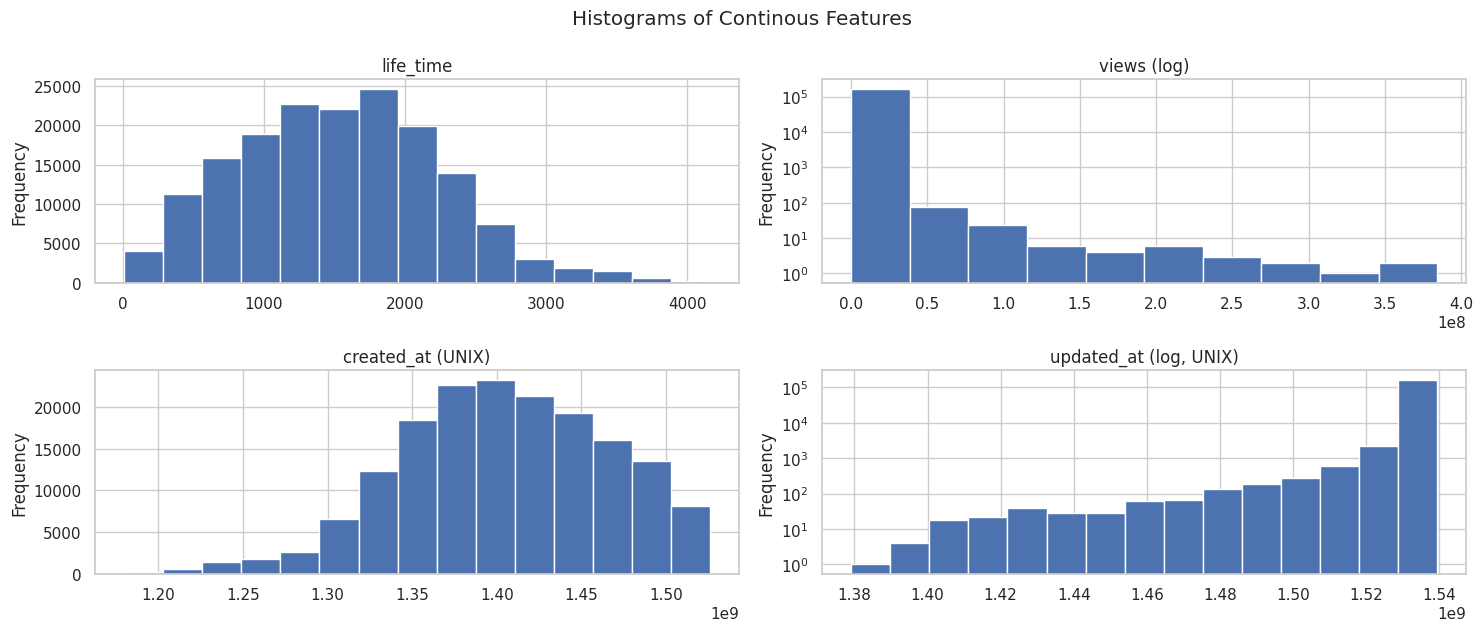

In [ ]:
# Visualization

sns.set(style="whitegrid")

# Histograms for continuous features
print('Histograms for continuous features\n')

# Create the figure and axes for individual control
fig, axes = plt.subplots(2, 2, figsize=(15, 6)) # 2 row, 2 columns

# Plot 'life_time' on the first subplot
features_df['life_time'].plot(kind='hist', bins=15,ax=axes[0, 0], title='life_time')

# Plot 'views' on the second subplot
features_df['views'].plot(kind='hist', log=True,ax=axes[0, 1], title="views (log)")

features_df["created_at"].plot(kind='hist', bins=15, ax=axes[1, 0],title='created_at (UNIX)')
features_df["updated_at"].plot(kind='hist', bins=15,ax=axes[1, 1], title='updated_at (log, UNIX)', log=True)
plt.tight_layout()
plt.suptitle("Histograms of Continous Features", y=1.05)
plt.show()

Count plots for categorical features



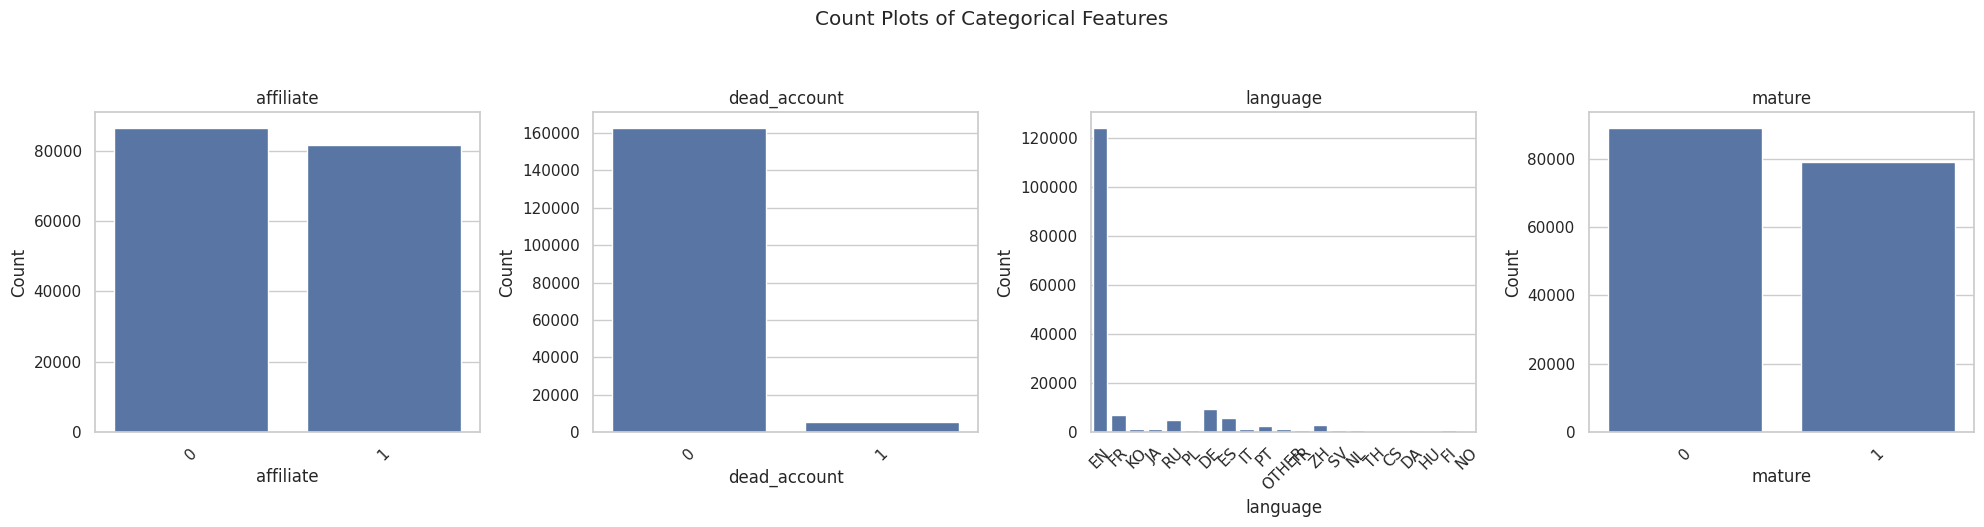

In [ ]:
# Visualization

print("Count plots for categorical features\n")

# Set up a 1x4 subplot grid (since there are 4 features)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot each feature in its own subplot
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=features_df, ax=axes[i])
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)
plt.suptitle("Count Plots of Categorical Features", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Log-Scaling continous data

features_df["views_log"]=np.log(features_df["views"]+ 1e-6)
features_df["updated_at_log"]=np.log(features_df["updated_at"])
features_df["created_at_log"]=np.log(features_df["created_at"])
features_df["life_time_log"]=np.log(features_df["life_time"])


In [ ]:
# Hot-encoding language variable
language_dummies = pd.get_dummies(features_df['language'], prefix='lang')
features_df = pd.concat([features_df, language_dummies], axis=1)

In [ ]:
features_overall=features_df.drop(columns=["numeric_id","language","views", "updated_at", "created_at","life_time"]).astype(np.float32)
features_overall

,mature,dead_account,affiliate,views_log,updated_at_log,created_at_log,life_time_log,lang_CS,lang_DA,lang_DE,...,lang_NL,lang_NO,lang_OTHER,lang_PL,lang_PT,lang_RU,lang_SV,lang_TH,lang_TR,lang_ZH
0,1.0,0.0,1.0,8.971956,21.154594,21.098671,6.876265,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,6.214608,21.154371,20.990053,7.900637,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,12.854489,21.154594,20.960098,8.054840,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,5.955837,21.153978,21.075493,7.203405,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,7.818430,21.154539,21.049023,7.486613,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,0.0,0.0,0.0,8.510169,21.154371,21.107830,6.697034,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168110,1.0,0.0,0.0,8.325548,21.154594,21.030449,7.640123,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168111,0.0,0.0,1.0,8.173293,21.154484,21.048149,7.493874,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168112,1.0,0.0,0.0,13.702046,21.154594,21.026949,7.666222,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Map IDs to row indices
id_to_index = {id_: i for i, id_ in enumerate(features_df['numeric_id'])}

# Filter edges to those with both nodes in features_df
edges_filtered = edges_df[
    edges_df['numeric_id_1'].isin(id_to_index) &
    edges_df['numeric_id_2'].isin(id_to_index)
]

# Convert to edge index
edge_index = torch.tensor([
    edges_filtered['numeric_id_1'].map(id_to_index).values,
    edges_filtered['numeric_id_2'].map(id_to_index).values
], dtype=torch.long)

# Ensuring undirectedness of the graph
edge_index = to_undirected(edge_index)

<ipython-input-13-1848212117>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([


In [ ]:
# Large data with all features
x_all = torch.tensor(features_overall.values, dtype=torch.float)
data_all = Data(x=x_all, edge_index=edge_index)

In [ ]:
# Calculate statistics
num_nodes = data_all.num_nodes
num_edges = data_all.num_edges // 2  # Since we added reciprocal edges
average_degree = (2 * num_edges) / num_nodes  # Each edge counts for both nodes

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {average_degree:.2f}")

# Check if the graph is undirected (optional)
print(f"Graph is undirected: {is_undirected(data_all.edge_index)}")

Number of nodes: 168114
Number of edges: 6797557
Average degree: 80.87
Graph is undirected: True


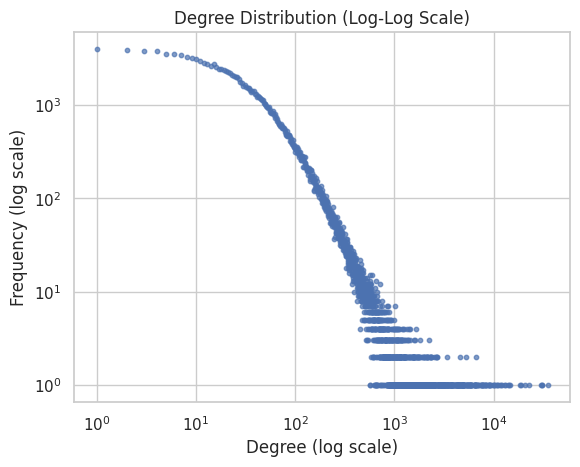

In [ ]:
# Visualizing edge degrees
deg = torch.bincount(data_all.edge_index[1]).numpy()
unique_degrees, deg_counts = np.unique(deg, return_counts=True)

plt.scatter(unique_degrees, deg_counts, s=10, alpha=0.7)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution (Log-Log Scale)')
plt.grid(True)
plt.show()


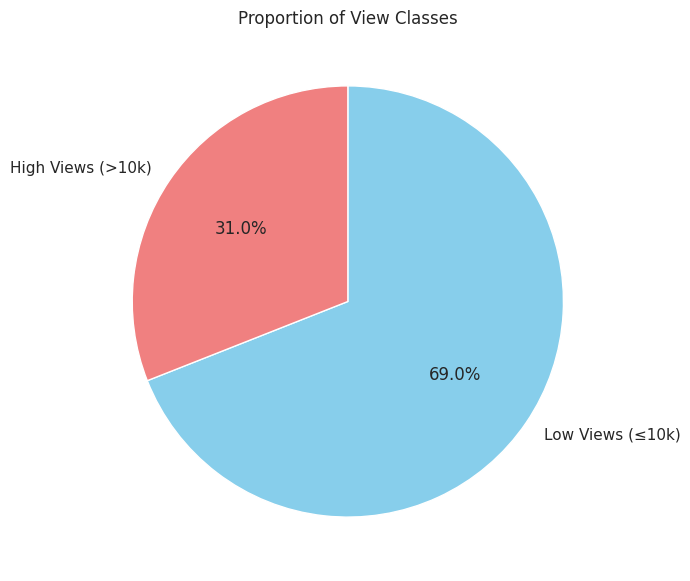

In [ ]:
# Visualizing target classes
high_views_binary = (features_df["views"] > 10_000).astype(int)

# Plot pie chart of class proportions
plt.figure(figsize=(7, 7))
high_views_binary.value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['Low Views (≤10k)', 'High Views (>10k)'],
    colors=['skyblue', 'lightcoral'],
    startangle=90,
    counterclock=False
)
plt.title('Proportion of View Classes')
plt.ylabel('')
plt.show()

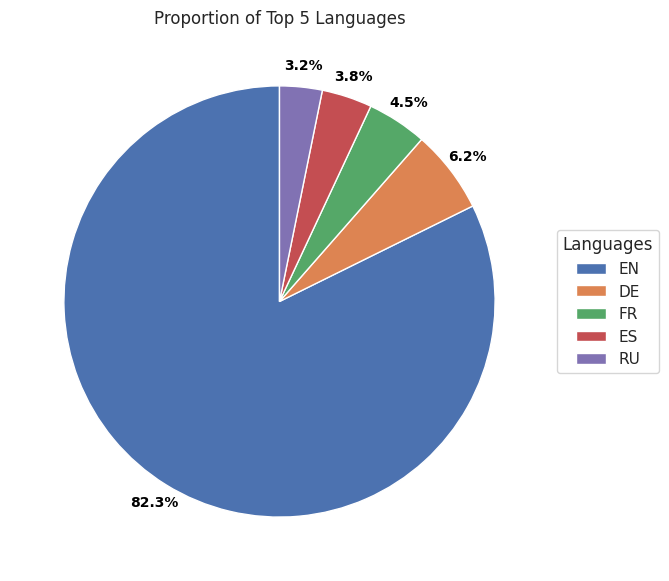

In [ ]:
#Visualizing language target

## Get top 5 languages and their counts
top_languages = features_df["language"].value_counts().nlargest(5)

sizes = top_languages.values
labels = top_languages.index

fig, ax = plt.subplots(figsize=(7,7))

wedges, texts, autotexts = ax.pie(
    sizes, labels=None, autopct='%1.1f%%', startangle=90,
    pctdistance=1.1,
    labeldistance=1.2
)

## Move the percentage labels (autotexts) further outside
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')
    autotext.set_weight('bold')

## Add a legend for labels (categories)
ax.legend(wedges, labels, title="Languages", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Proportion of Top 5 Languages")
plt.ylabel('')
plt.show()

Correlation matrix



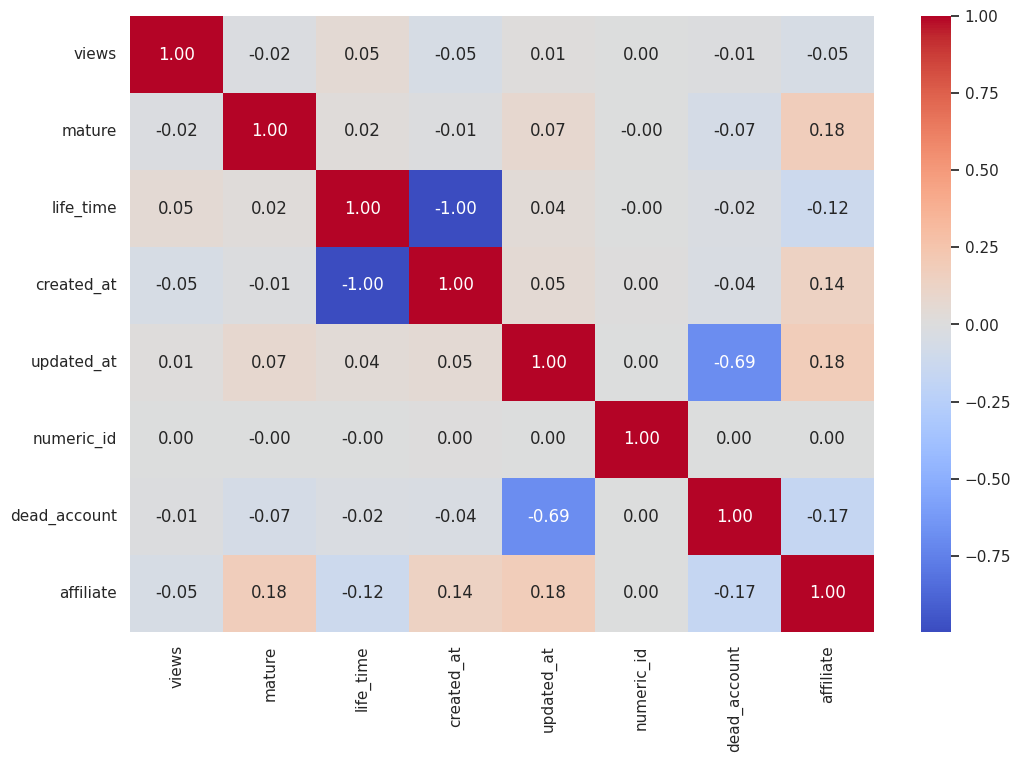

In [ ]:
# Confusion Matrix Visualization
numeric_data = features_df.select_dtypes(include=[np.number]).drop(columns=["updated_at_log", "created_at_log", "views_log", "life_time_log"])  # This only includes numeric columns
corr_matrix = numeric_data.corr()


# Plot the correlation matrix
print('Correlation matrix\n')
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
#plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [ ]:
# Extracting features for Task A
features_df['high_views'] = (features_df['views'] > 10_000).astype(int)
features_task_a = features_df.drop(columns=["views","views_log", "updated_at","life_time", "numeric_id", "language", "created_at","created_at_log"]).astype(np.float32)
features_task_a

,mature,dead_account,affiliate,updated_at_log,life_time_log,lang_CS,lang_DA,lang_DE,lang_EN,lang_ES,...,lang_NO,lang_OTHER,lang_PL,lang_PT,lang_RU,lang_SV,lang_TH,lang_TR,lang_ZH,high_views
0,1.0,0.0,1.0,21.154594,6.876265,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,21.154371,7.900637,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,21.154594,8.054840,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,21.153978,7.203405,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,21.154539,7.486613,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168109,0.0,0.0,0.0,21.154371,6.697034,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168110,1.0,0.0,0.0,21.154594,7.640123,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168111,0.0,0.0,1.0,21.154484,7.493874,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168112,1.0,0.0,0.0,21.154594,7.666222,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Extracting features for Task B
top_languages = features_df['language'].value_counts().nlargest(5).index.tolist()
features_df['language_label'] = features_df['language'].apply(lambda x: x if x in top_languages else 'OTHER')
language_mapping = {lang: idx for idx, lang in enumerate(features_df['language_label'].unique())}
features_df['language_target'] = features_df['language_label'].map(language_mapping)

features_task_b = features_df.drop(columns=['numeric_id','language', 'language_label', "created_at", "created_at_log", "views", "life_time", "updated_at", "high_views"]+
                                           [col for col in features_df.columns if col.startswith('lang_')]).astype(np.float32)
print(language_mapping)
features_task_b

{'EN': 0, 'FR': 1, 'OTHER': 2, 'RU': 3, 'DE': 4, 'ES': 5}


,mature,dead_account,affiliate,views_log,updated_at_log,life_time_log,language_target
0,1.0,0.0,1.0,8.971956,21.154594,6.876265,0.0
1,0.0,0.0,0.0,6.214608,21.154371,7.900637,0.0
2,1.0,0.0,1.0,12.854489,21.154594,8.054840,0.0
3,0.0,0.0,0.0,5.955837,21.153978,7.203405,0.0
4,0.0,0.0,0.0,7.818430,21.154539,7.486613,0.0
...,...,...,...,...,...,...,...
168109,0.0,0.0,0.0,8.510169,21.154371,6.697034,0.0
168110,1.0,0.0,0.0,8.325548,21.154594,7.640123,0.0
168111,0.0,0.0,1.0,8.173293,21.154484,7.493874,0.0
168112,1.0,0.0,0.0,13.702046,21.154594,7.666222,0.0


In [ ]:
# Features as tensor (exclude target columns)
x_task_a = torch.tensor(features_task_a.drop(columns=['high_views']).values, dtype=torch.float)
y_task_a = torch.tensor(features_task_a['high_views'].values, dtype=torch.long)

x_task_b = torch.tensor(features_task_b.drop(columns=["language_target"]).values, dtype=torch.float)
y_task_b = torch.tensor(features_task_b['language_target'].values, dtype=torch.long)

# Graph Data objects
data_a = Data(x=x_task_a, y=y_task_a, edge_index=edge_index)
data_b = Data(x=x_task_b, y=y_task_b, edge_index=edge_index)

In [ ]:
# Splitting data for MLP Task A
train_size = int(0.6 * len(x_task_a))
val_size = int(0.2 * len(x_task_a))
test_size = len(x_task_a) - train_size - val_size

train_dataset_a, val_dataset_a, test_dataset_a = random_split(
    TensorDataset(x_task_a, y_task_a),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

In [ ]:
# Define which columns are numerical and which are dummy
dummy_indices = [0, 1, 2] + list(range(5, data_a.x.size(1)))  # dummies: first 3 + all language columns (assuming lang_* start at col 5)
numerical_indices = [3, 4]  # updated_at_log, life_time_log at columns 3 and 4

# Function for splitting featues into numerical and dummy
def split_features(X, numerical_indices, dummy_indices):
    return X[:, numerical_indices], X[:, dummy_indices]

# Function for recombining features
def combine_features(x_num_scaled, x_dummy, numerical_indices, dummy_indices, total_num_features):
    X_scaled = np.zeros((x_num_scaled.shape[0], total_num_features))
    for i, idx in enumerate(numerical_indices):
        X_scaled[:, idx] = x_num_scaled[:, i]
    for i, idx in enumerate(dummy_indices):
        X_scaled[:, idx] = x_dummy[:, i]
    return X_scaled


# Scaling Data:

## Convert datasets to numpy arrays (features only)
X_train = train_dataset_a[:][0].numpy()
X_val = val_dataset_a[:][0].numpy()
X_test = test_dataset_a[:][0].numpy()

## Split numerical and dummy features
X_train_num, X_train_dummy = split_features(X_train, numerical_indices, dummy_indices)
X_val_num, X_val_dummy = split_features(X_val, numerical_indices, dummy_indices)
X_test_num, X_test_dummy = split_features(X_test, numerical_indices, dummy_indices)

## Fit scaler on training numerical features only
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)

## Transform validation and test numerical features
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

## Combine scaled numericals with untouched dummies
total_features = X_train.shape[1]
X_train_scaled = combine_features(X_train_num_scaled, X_train_dummy, numerical_indices, dummy_indices, total_features)
X_val_scaled = combine_features(X_val_num_scaled, X_val_dummy, numerical_indices, dummy_indices, total_features)
X_test_scaled = combine_features(X_test_num_scaled, X_test_dummy, numerical_indices, dummy_indices, total_features)

## Convert labels (unchanged)
y_train = train_dataset_a[:][1]
y_val = val_dataset_a[:][1]
y_test = test_dataset_a[:][1]

## Convert back to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

## Create new datasets with scaled features
train_dataset_a = TensorDataset(X_train_tensor, y_train)
val_dataset_a = TensorDataset(X_val_tensor, y_val)
test_dataset_a = TensorDataset(X_test_tensor, y_test)

In [ ]:
# Defining class weight function for later use
def get_class_weights(labels, mask=None, device=device, smoothing="log"):
    """Compute class weights for imbalanced classification."""
    if mask is not None:
        labels = labels[mask]

    labels_np = labels.cpu().numpy()
    classes = np.unique(labels_np)

    class_weights = compute_class_weight(class_weight='balanced',
                                       classes=classes,
                                       y=labels_np)

    if smoothing == 'log':
        class_weights = np.log1p(class_weights)
    elif smoothing == 'sqrt':
        class_weights = np.sqrt(class_weights)

    weight_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
    return weight_tensor

In [ ]:
# Define the MLP model for binary classification in Task A
class MLP_Classifier(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = x_task_a.shape[1]
mlp_A = MLP_Classifier(input_dim).to(device)


summary(mlp_A, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           3,456
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 2]              66
Total params: 13,858
Trainable params: 13,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Tot

In [ ]:
# EARLY STOPPING
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')

# Training function
def train_mlp(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, model_name):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch: {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

        early_stopper(val_losses[-1], model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load(f'{model_name}_checkpoint.pt'))
    return train_losses, val_losses

In [1]:
# Create DataLoaders for Task A
batch_size = 64
train_loader = DataLoader(train_dataset_a, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_a, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_a, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=get_class_weights(y_task_a, device=device))
optimizer = optim.Adam(mlp_A.parameters(), lr=0.001, weight_decay=0.001)

# Initialize early stopping
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='mlpA_checkpoint.pt')

# Train the model
epochs = 500
train_losses, val_losses = train_mlp(epochs=epochs, model=mlp_A, optimizer=optimizer, criterion=criterion, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, model_name='mlpA')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'DataLoader' is not defined


---------------MLP MODEL VALIDATION---------------

Accuracy: 0.6982927844863482
Classification Report:
                 precision    recall  f1-score   support

<=10,000 Views     0.8596    0.6740    0.7555     23258
 >10,000 Views     0.5071    0.7529    0.6061     10364

      accuracy                         0.6983     33622
     macro avg     0.6834    0.7134    0.6808     33622
  weighted avg     0.7509    0.6983    0.7095     33622



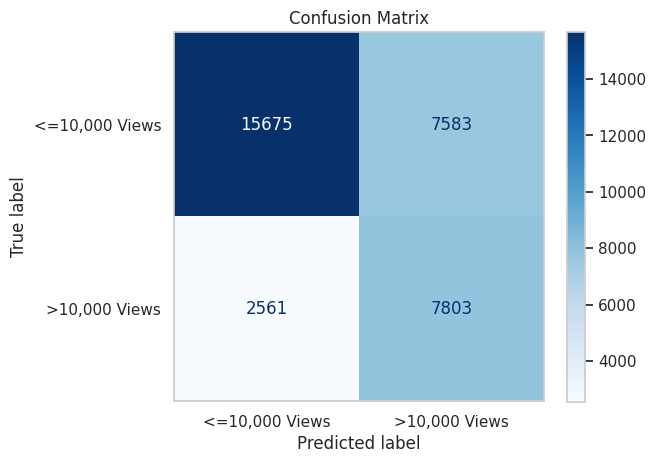


---------------MLP MODEL TEST---------------

Accuracy: 0.6995895788722342
Classification Report:
                 precision    recall  f1-score   support

<=10,000 Views     0.8545    0.6795    0.7570     23154
 >10,000 Views     0.5121    0.7440    0.6067     10470

      accuracy                         0.6996     33624
     macro avg     0.6833    0.7118    0.6818     33624
  weighted avg     0.7479    0.6996    0.7102     33624



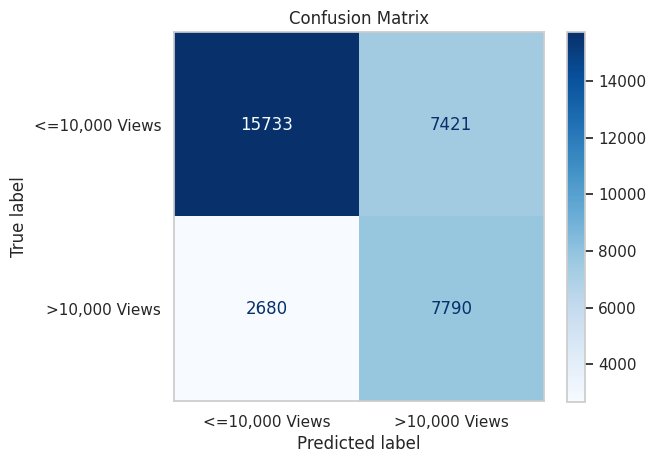

In [ ]:
# Evaluation function
def evaluate_model(data, model, class_labels, mask_type='val'):
    """Generic evaluation function that works for both MLP and GNN models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Handle different input types
    if isinstance(data, DataLoader):  # MLP case
        y_true = []
        y_preds = []
        with torch.no_grad():
            for inputs, labels in data:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                y_preds.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
    else:  # GNN case
        data = data.to(device)
        mask = data.val_mask if mask_type == 'val' else data.test_mask
        with torch.no_grad():
            if hasattr(model, 'forward_with_edge_index'):  # GraphSAGE
                outputs = model(data.x, data.edge_index)
            else:  # Regular GNN
                outputs = model(data)
            _, predicted = torch.max(outputs[mask], 1)
            y_preds = predicted.cpu().numpy()
            y_true = data.y[mask].cpu().numpy()

    # Common evaluation metrics
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(
        y_true, y_preds, target_names=class_labels, digits=4
    ))

    cm = confusion_matrix(y_true, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

    return accuracy


# Evaluate MLP model
print("\n---------------MLP MODEL VALIDATION---------------\n")
mlpA_acc_val = evaluate_model(val_loader, mlp_A, class_labels=["<=10,000 Views", ">10,000 Views"])

print("\n---------------MLP MODEL TEST---------------\n")
mlpA_acc_test = evaluate_model(test_loader, mlp_A, class_labels=["<=10,000 Views", ">10,000 Views"])

In [ ]:
# Define GNN model for Task A
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # Fixed typo from conv1 to conv1
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.classifier = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Initialize GNN for Task A
input_dim = X_train.shape[1]
hidden_dim = 32
gnn_A = GNN(input_dim, hidden_dim).to(device)

# Print model architecture summary (layers and parameters)
print(gnn_A)

GNN(
  (conv1): GCNConv(26, 32)
  (conv2): GCNConv(32, 16)
  (classifier): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Create masks for GNN training
class_indices = [torch.where(data_a.y == c)[0] for c in torch.unique(data_a.y)]
train_idx = []
val_idx = []
test_idx = []

for indices in class_indices:
    n_samples = len(indices)
    n_train = int(n_samples * 0.6)
    n_val = int(n_samples * 0.2)
    n_test = n_samples - n_train - n_val

    indices = indices[torch.randperm(n_samples)]
    train_idx.append(indices[:n_train])
    val_idx.append(indices[n_train:n_train + n_val])
    test_idx.append(indices[n_train + n_val:n_train + n_val + n_test])

train_idx = torch.cat(train_idx)
val_idx = torch.cat(val_idx)
test_idx = torch.cat(test_idx)

train_mask = torch.zeros(data_a.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data_a.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data_a.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data_a.train_mask = train_mask
data_a.val_mask = val_mask
data_a.test_mask = test_mask

In [ ]:
# Feature scaling for GNN
x = data_a.x.detach().cpu().numpy()
train_mask = data_a.train_mask.detach().cpu().numpy()

x_dummy = x[:, dummy_indices]
x_num = x[:, numerical_indices]

scaler = StandardScaler()
scaler.fit(x_num[train_mask])
x_num_scaled = scaler.transform(x_num)
x_scaled = np.hstack([x_dummy, x_num_scaled])
data_a.x = torch.FloatTensor(x_scaled).to(device)

In [ ]:
# Define the training function for the GNN
def train_gnn(epochs, model, optimizer, criterion, data, early_stopper, model_name):
    train_losses = []
    val_losses = []

    data = data.to(device)
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Handle different forward methods
        if isinstance(model, GNN):
            output = model(data)

        else:  # Regular GNN
            output = model(data.x, data.edge_index)


        train_loss = criterion(output[data.train_mask], data.y[data.train_mask])
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

        model.eval()
        with torch.no_grad():
            if isinstance(model, GNN):
                val_output = model(data)

            else:
                val_output = model(data.x, data.edge_index)
            val_loss = criterion(val_output[data.val_mask], data.y[data.val_mask])
            val_losses.append(val_loss.item())

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        early_stopper(val_losses[-1], model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load(f'{model_name}_checkpoint.pt'))
    return train_losses, val_losses

Epoch 1, Train Loss: 0.7036, Val Loss: 0.6965
Validation loss decreased (0.696544 --> 0.696544). Saving model...
Epoch 2, Train Loss: 0.6999, Val Loss: 0.6937
Validation loss decreased (0.696544 --> 0.693664). Saving model...
Epoch 3, Train Loss: 0.6966, Val Loss: 0.6912
Validation loss decreased (0.693664 --> 0.691234). Saving model...
Epoch 4, Train Loss: 0.6934, Val Loss: 0.6890
Validation loss decreased (0.691234 --> 0.688989). Saving model...
Epoch 5, Train Loss: 0.6908, Val Loss: 0.6868
Validation loss decreased (0.688989 --> 0.686812). Saving model...
Epoch 6, Train Loss: 0.6886, Val Loss: 0.6845
Validation loss decreased (0.686812 --> 0.684533). Saving model...
Epoch 7, Train Loss: 0.6862, Val Loss: 0.6820
Validation loss decreased (0.684533 --> 0.681960). Saving model...
Epoch 8, Train Loss: 0.6828, Val Loss: 0.6790
Validation loss decreased (0.681960 --> 0.679000). Saving model...
Epoch 9, Train Loss: 0.6808, Val Loss: 0.6759
Validation loss decreased (0.679000 --> 0.675865).

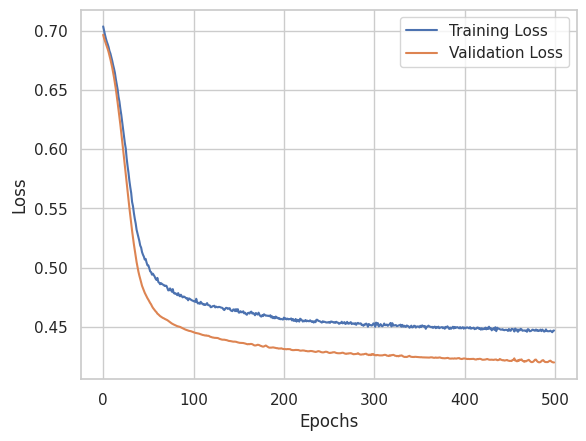

In [ ]:
# Train GNN model
optimizer = optim.Adam(gnn_A.parameters(), lr=0.005, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss(weight=get_class_weights(y_task_a, mask=data_a.train_mask, device=device))
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='gnnA_checkpoint.pt')

epochs = 500
train_losses, val_losses = train_gnn(epochs=500, model=gnn_A, optimizer=optimizer, criterion=criterion, data=data_a, early_stopper=early_stopper, model_name='gnnA')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


---------------GNN MODEL (Validation)---------------

Accuracy: 0.8125334602343703
Classification Report:
                    precision    recall  f1-score   support

 Low Views (≤10k)     0.8912    0.8296    0.8593     23204
High Views (>10k)     0.6712    0.7744    0.7191     10418

         accuracy                         0.8125     33622
        macro avg     0.7812    0.8020    0.7892     33622
     weighted avg     0.8230    0.8125    0.8159     33622



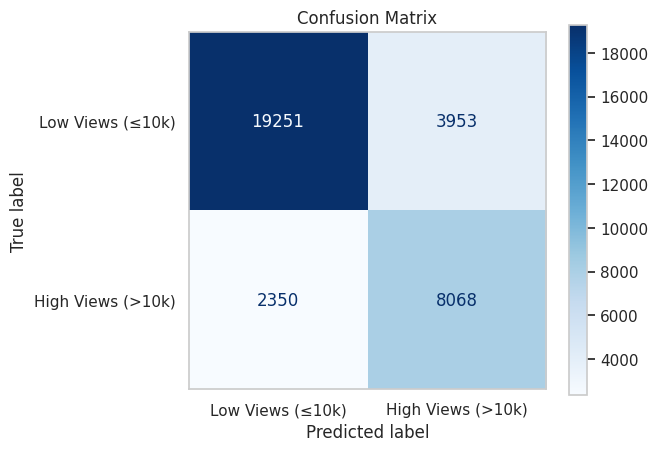


---------------GNN MODEL (Test)---------------

Accuracy: 0.8091839162502974
Classification Report:
                    precision    recall  f1-score   support

 Low Views (≤10k)     0.8873    0.8288    0.8570     23206
High Views (>10k)     0.6674    0.7656    0.7132     10418

         accuracy                         0.8092     33624
        macro avg     0.7774    0.7972    0.7851     33624
     weighted avg     0.8192    0.8092    0.8125     33624



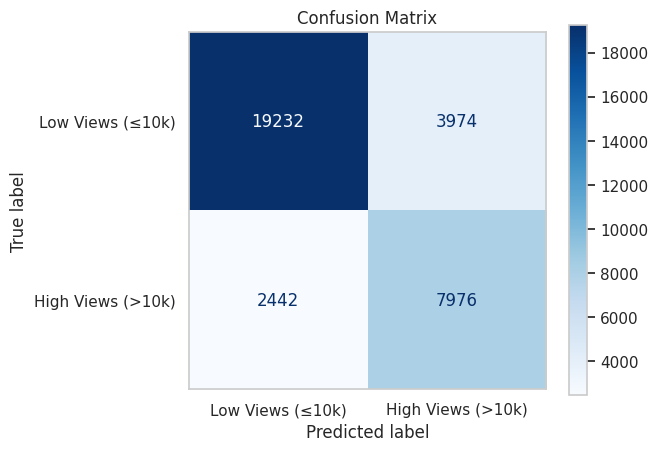

In [ ]:
print("\n---------------GNN MODEL (Validation)---------------\n")
gnn_val_accuracy_A = evaluate_model(data_a, gnn_A, mask_type='val', class_labels=['Low Views (≤10k)', 'High Views (>10k)'])

print("\n---------------GNN MODEL (Test)---------------\n")
gnn_test_accuracy_A = evaluate_model(data_a, gnn_A, mask_type='test', class_labels=['Low Views (≤10k)', 'High Views (>10k)'])

TASK B

In [ ]:
# Splitting data for MLP Task B
train_size = int(0.6 * len(x_task_b))
val_size = int(0.2 * len(x_task_b))
test_size = len(x_task_b) - train_size - val_size

train_dataset_b, val_dataset_b, test_dataset_b = random_split(
    TensorDataset(x_task_b, y_task_b),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
dummy_indices = [0, 1, 2]       # mature, dead_account, affiliate
numerical_indices = [3, 4, 5]   # views_log, updated_at_log, life_time_log

# Feature scaling for Task B MLP
X_train = train_dataset_b[:][0].numpy()
X_val = val_dataset_b[:][0].numpy()
X_test = test_dataset_b[:][0].numpy()

X_train_num, X_train_dummy = split_features(X_train, numerical_indices, dummy_indices)
X_val_num, X_val_dummy = split_features(X_val, numerical_indices, dummy_indices)
X_test_num, X_test_dummy = split_features(X_test, numerical_indices, dummy_indices)

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

total_features = X_train.shape[1]
X_train_scaled = combine_features(X_train_num_scaled, X_train_dummy, numerical_indices, dummy_indices, total_features)
X_val_scaled = combine_features(X_val_num_scaled, X_val_dummy, numerical_indices, dummy_indices, total_features)
X_test_scaled = combine_features(X_test_num_scaled, X_test_dummy, numerical_indices, dummy_indices, total_features)

y_train = train_dataset_b[:][1]
y_val = val_dataset_b[:][1]
y_test = test_dataset_b[:][1]

X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

train_dataset_b = TensorDataset(X_train_tensor, y_train)
val_dataset_b = TensorDataset(X_val_tensor, y_val)
test_dataset_b = TensorDataset(X_test_tensor, y_test)

In [ ]:
# MLP for Task B
class MLP_Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

input_dim = x_task_b.shape[1]
output_dim = len(y_task_b.unique())
mlp_B = MLP_Classifier(input_dim, output_dim).to(device)
summary(mlp_B, input_size=(input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             896
              ReLU-2                  [-1, 128]               0
           Dropout-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
           Dropout-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 6]             198
Total params: 11,430
Trainable params: 11,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Tot

Epoch: 1, Training Loss: 1.6648, Validation Loss: 1.6301
Validation loss decreased (1.630099 --> 1.630099). Saving model...
Epoch: 2, Training Loss: 1.6427, Validation Loss: 1.6267
Validation loss decreased (1.630099 --> 1.626728). Saving model...
Epoch: 3, Training Loss: 1.6380, Validation Loss: 1.6239
Validation loss decreased (1.626728 --> 1.623877). Saving model...
Epoch: 4, Training Loss: 1.6375, Validation Loss: 1.6242
Epoch: 5, Training Loss: 1.6359, Validation Loss: 1.6232
Validation loss decreased (1.623877 --> 1.623167). Saving model...
Epoch: 6, Training Loss: 1.6360, Validation Loss: 1.6243
Epoch: 7, Training Loss: 1.6356, Validation Loss: 1.6222
Validation loss decreased (1.623167 --> 1.622190). Saving model...
Epoch: 8, Training Loss: 1.6363, Validation Loss: 1.6228
Epoch: 9, Training Loss: 1.6341, Validation Loss: 1.6238
Epoch: 10, Training Loss: 1.6346, Validation Loss: 1.6235
Epoch: 11, Training Loss: 1.6358, Validation Loss: 1.6187
Validation loss decreased (1.622190 

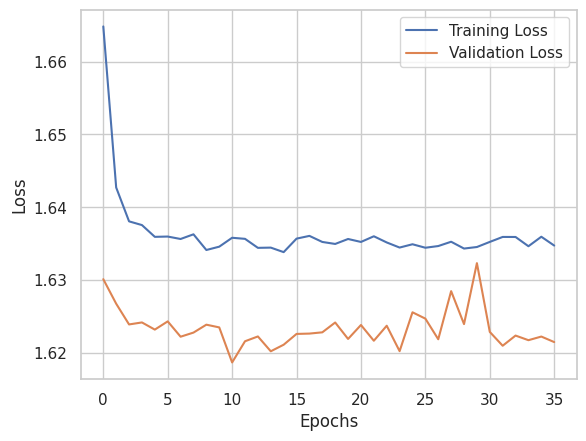

In [ ]:
# Train MLP for Task B
batch_size=64
train_loader = DataLoader(train_dataset_b, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_b, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_b, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss(weight=get_class_weights(labels=data_b.y, device=device))
optimizer = optim.Adam(mlp_B.parameters(), lr=0.001, weight_decay=0.001)
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='mlpB_checkpoint.pt')

# Train the model and plot losses
epochs =  500
train_losses, val_losses = train_mlp(epochs=epochs, model=mlp_B, optimizer=optimizer, criterion=criterion, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, model_name='mlpB')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


---------------MLP MODEL VALIDATION---------------

Accuracy: 0.6221819047052525
Classification Report:
               precision    recall  f1-score   support

          EN     0.8017    0.7697    0.7854     24833
          FR     0.0000    0.0000    0.0000      1418
       OTHER     0.2125    0.4142    0.2809      3404
          RU     0.0000    0.0000    0.0000       938
          DE     0.1256    0.2069    0.1563      1909
          ES     0.0000    0.0000    0.0000      1120

    accuracy                         0.6222     33622
   macro avg     0.1900    0.2318    0.2038     33622
weighted avg     0.6208    0.6222    0.6174     33622



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


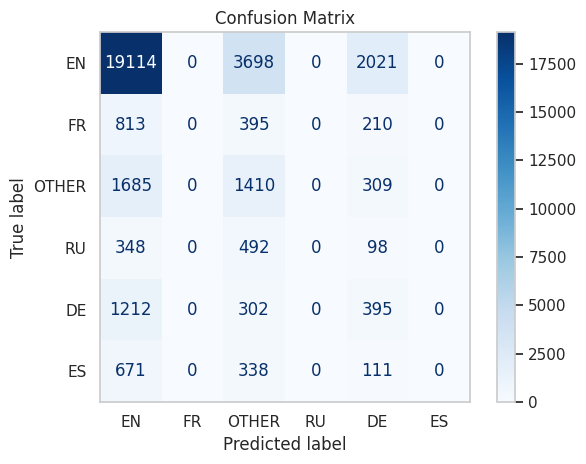


---------------MLP MODEL TEST---------------

Accuracy: 0.625862479181537
Classification Report:
               precision    recall  f1-score   support

          EN     0.8052    0.7703    0.7873     24975
          FR     0.0000    0.0000    0.0000      1249
       OTHER     0.2053    0.4021    0.2718      3397
          RU     0.0000    0.0000    0.0000       922
          DE     0.1432    0.2290    0.1762      1926
          ES     0.0000    0.0000    0.0000      1155

    accuracy                         0.6259     33624
   macro avg     0.1923    0.2336    0.2059     33624
weighted avg     0.6270    0.6259    0.6224     33624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


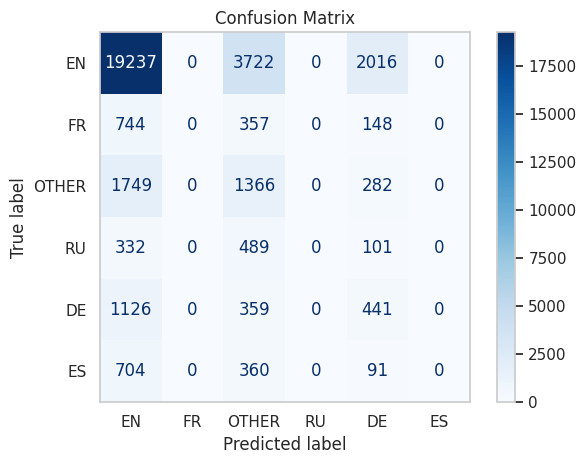

In [ ]:
# Evaluate MLP for Task B
print("\n---------------MLP MODEL VALIDATION---------------\n")
mlpB_acc_val = evaluate_model(val_loader, mlp_B, class_labels=['EN', 'FR', 'OTHER', 'RU', 'DE', 'ES'])

print("\n---------------MLP MODEL TEST---------------\n")
mlpB_acc_test = evaluate_model(test_loader, mlp_B, class_labels=['EN', 'FR', 'OTHER', 'RU', 'DE', 'ES'])

In [ ]:
# GNN for Task B
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=6):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.classifier = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

input_dim = x_task_b.shape[1]
hidden_dim = 32
output_dim = len(data_b.y.unique())
gnn_B = GNN(input_dim, hidden_dim, output_dim).to(device)


# Print model architecture summary (layers and parameters)
print(gnn_B)

GNN(
  (conv1): GCNConv(6, 32)
  (conv2): GCNConv(32, 16)
  (classifier): Linear(in_features=16, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Create masks for GNN Task B
class_indices = [torch.where(data_b.y == c)[0] for c in torch.unique(data_b.y)]
train_idx = []
val_idx = []
test_idx = []

for indices in class_indices:
    n_samples = len(indices)
    n_train = int(n_samples * 0.6)
    n_val = int(n_samples * 0.2)
    n_test = n_samples - n_train - n_val

    indices = indices[torch.randperm(n_samples)]
    train_idx.append(indices[:n_train])
    val_idx.append(indices[n_train:n_train + n_val])
    test_idx.append(indices[n_train + n_val:n_train + n_val + n_test])

train_idx = torch.cat(train_idx)
val_idx = torch.cat(val_idx)
test_idx = torch.cat(test_idx)

train_mask = torch.zeros(data_b.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data_b.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data_b.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data_b.train_mask = train_mask
data_b.val_mask = val_mask
data_b.test_mask = test_mask


In [ ]:
#Feature scaling for GNN Task B
x = data_b.x.detach().cpu().numpy()
train_mask = data_b.train_mask.detach().cpu().numpy()

x_dummy = x[:, dummy_indices]
x_num = x[:, numerical_indices]

scaler = StandardScaler()
scaler.fit(x_num[train_mask])
x_num_scaled = scaler.transform(x_num)
x_scaled = np.hstack([x_dummy, x_num_scaled])
data_b.x = torch.FloatTensor(x_scaled).to(device)

Epoch 1, Train Loss: 1.7734, Val Loss: 1.7609
Validation loss decreased (1.760877 --> 1.760877). Saving model...
Epoch 2, Train Loss: 1.7663, Val Loss: 1.7533
Validation loss decreased (1.760877 --> 1.753303). Saving model...
Epoch 3, Train Loss: 1.7561, Val Loss: 1.7463
Validation loss decreased (1.753303 --> 1.746331). Saving model...
Epoch 4, Train Loss: 1.7507, Val Loss: 1.7399
Validation loss decreased (1.746331 --> 1.739874). Saving model...
Epoch 5, Train Loss: 1.7452, Val Loss: 1.7339
Validation loss decreased (1.739874 --> 1.733882). Saving model...
Epoch 6, Train Loss: 1.7397, Val Loss: 1.7284
Validation loss decreased (1.733882 --> 1.728360). Saving model...
Epoch 7, Train Loss: 1.7344, Val Loss: 1.7233
Validation loss decreased (1.728360 --> 1.723274). Saving model...
Epoch 8, Train Loss: 1.7292, Val Loss: 1.7185
Validation loss decreased (1.723274 --> 1.718549). Saving model...
Epoch 9, Train Loss: 1.7265, Val Loss: 1.7141
Validation loss decreased (1.718549 --> 1.714121).

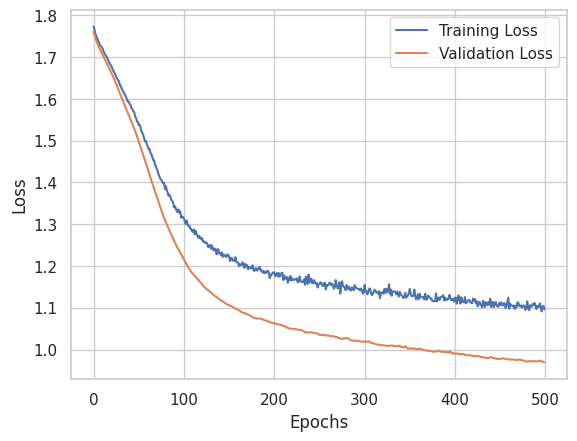

In [ ]:
# Train GNN for Task B
optimizer = optim.Adam(gnn_B.parameters(), lr=0.005, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss(weight=get_class_weights(labels=data_b.y, mask=data_b.train_mask, device=device))
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='gnnB_checkpoint.pt')

epochs = 500
train_losses, val_losses = train_gnn(epochs=500, model=gnn_B, optimizer=optimizer, criterion=criterion, data=data_b, early_stopper=early_stopper, model_name='gnnB')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


---------------GNN MODEL (Validation)---------------

Accuracy: 0.8342950624628197
Classification Report:
               precision    recall  f1-score   support

          EN     0.9183    0.9387    0.9284     24882
          FR     0.3740    0.4238    0.3974      1359
       OTHER     0.6015    0.4813    0.5347      3391
          RU     0.5068    0.5373    0.5217       964
          DE     0.7676    0.7761    0.7718      1885
          ES     0.5015    0.4416    0.4697      1139

    accuracy                         0.8343     33620
   macro avg     0.6116    0.5998    0.6039     33620
weighted avg     0.8300    0.8343    0.8312     33620



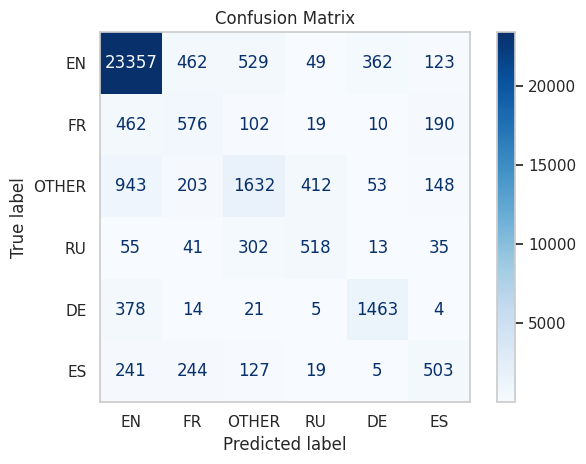


---------------GNN MODEL (Test)---------------

Accuracy: 0.8342950624628197
Classification Report:
               precision    recall  f1-score   support

          EN     0.9183    0.9387    0.9284     24882
          FR     0.3740    0.4238    0.3974      1359
       OTHER     0.6015    0.4813    0.5347      3391
          RU     0.5068    0.5373    0.5217       964
          DE     0.7676    0.7761    0.7718      1885
          ES     0.5015    0.4416    0.4697      1139

    accuracy                         0.8343     33620
   macro avg     0.6116    0.5998    0.6039     33620
weighted avg     0.8300    0.8343    0.8312     33620



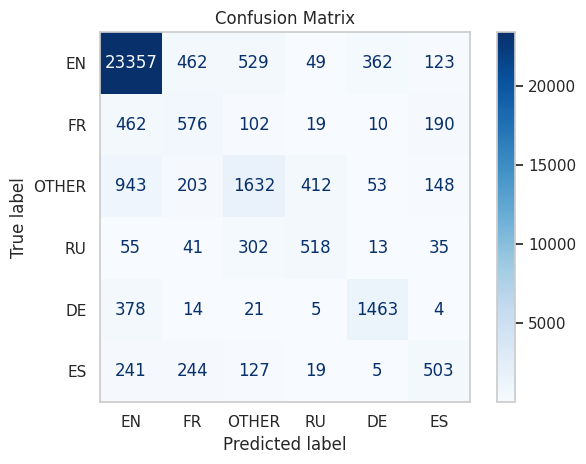

In [ ]:
# Evaluate GNN model on validation set
print("\n---------------GNN MODEL (Validation)---------------\n")
gnn_val_accuracy_B = evaluate_model(data_b, gnn_B, mask_type='val', class_labels=['EN', 'FR', 'OTHER', 'RU', 'DE', 'ES'])

# Evaluate GNN model on test set
print("\n---------------GNN MODEL (Test)---------------\n")
gnn_test_accuracy_B = evaluate_model(data_b, gnn_B, mask_type='val', class_labels=['EN', 'FR', 'OTHER', 'RU', 'DE', 'ES'])


GraphSAGE

In [ ]:
# GraphSAGE for Task B
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = nn.Dropout(0.5)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        if batch is None:  # Node classification
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            return self.lin(x)
        else:  # Graph classification
            x = self.conv1(x, edge_index)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            x = F.relu(x)
            x = global_mean_pool(x, batch)
            return self.lin(x)

# Initialize GraphSAGE
gs_B = GraphSAGE(
    in_channels=data_b.num_node_features,
    hidden_channels=64,
    out_channels=len(data_b.y.unique())
).to(device)

Epoch 1, Train Loss: 1.7795, Val Loss: 1.7340
Validation loss decreased (1.734020 --> 1.734020). Saving model...
Epoch 2, Train Loss: 1.7581, Val Loss: 1.7199
Validation loss decreased (1.734020 --> 1.719939). Saving model...
Epoch 3, Train Loss: 1.7460, Val Loss: 1.7129
Validation loss decreased (1.719939 --> 1.712929). Saving model...
Epoch 4, Train Loss: 1.7377, Val Loss: 1.7083
Validation loss decreased (1.712929 --> 1.708299). Saving model...
Epoch 5, Train Loss: 1.7303, Val Loss: 1.7032
Validation loss decreased (1.708299 --> 1.703220). Saving model...
Epoch 6, Train Loss: 1.7261, Val Loss: 1.6970
Validation loss decreased (1.703220 --> 1.697012). Saving model...
Epoch 7, Train Loss: 1.7183, Val Loss: 1.6901
Validation loss decreased (1.697012 --> 1.690051). Saving model...
Epoch 8, Train Loss: 1.7136, Val Loss: 1.6829
Validation loss decreased (1.690051 --> 1.682877). Saving model...
Epoch 9, Train Loss: 1.7033, Val Loss: 1.6759
Validation loss decreased (1.682877 --> 1.675950).

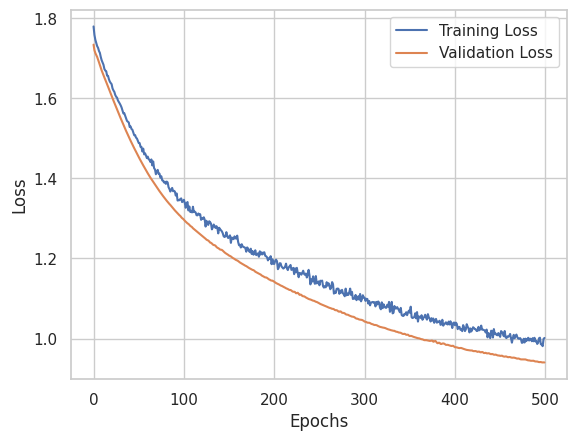

In [ ]:
# Train GraphSAGE

optimizer = optim.Adam(gs_B.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss(weight=get_class_weights(labels=data_b.y, mask=data_b.train_mask, device=device))
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='graphsage_checkpoint.pt')

epochs = 500
train_losses, val_losses = train_gnn(epochs=epochs, model=gs_B, optimizer=optimizer, criterion=criterion, data=data_b, early_stopper=early_stopper, model_name='graphsage')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate_graphsage(model, data, class_labels, mask_type='val'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Prepare data
    data = data.to(device)
    mask = data.val_mask if mask_type == 'val' else data.test_mask

    # Forward pass - specific to GraphSAGE
    with torch.no_grad():
        outputs = model(data.x, data.edge_index)  # Explicitly pass features and edge_index
        _, predicted = torch.max(outputs[mask], 1)
        y_pred = predicted.cpu().numpy()
        y_true = data.y[mask].cpu().numpy()

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nGraphSAGE Evaluation ({mask_type} set):")
    print("Accuracy: {:.4f}".format(accuracy))
    print("Classification Report:\n", classification_report(
        y_true, y_pred, target_names=class_labels, digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues')
    plt.title(f"GraphSAGE Confusion Matrix ({mask_type} set)")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

    return accuracy


---------------GraphSAGE MODEL (Validation)---------------


GraphSAGE Evaluation (val set):
Accuracy: 0.8446
Classification Report:
               precision    recall  f1-score   support

          EN     0.9347    0.9351    0.9349     24882
          FR     0.4730    0.5166    0.4938      1359
       OTHER     0.6044    0.5804    0.5921      3391
          RU     0.6102    0.6432    0.6263       964
          DE     0.7528    0.7544    0.7536      1885
          ES     0.3854    0.3661    0.3755      1139

    accuracy                         0.8446     33620
   macro avg     0.6268    0.6326    0.6294     33620
weighted avg     0.8446    0.8446    0.8446     33620



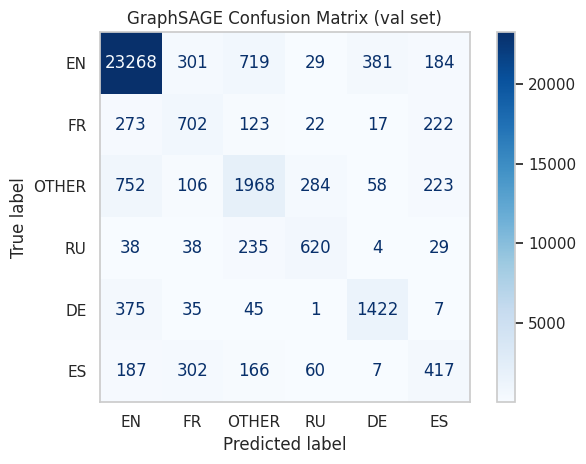


---------------GraphSAGE MODEL (Test)---------------


GraphSAGE Evaluation (test set):
Accuracy: 0.8411
Classification Report:
               precision    recall  f1-score   support

          EN     0.9342    0.9297    0.9319     24883
          FR     0.4552    0.5195    0.4852      1361
       OTHER     0.6064    0.5849    0.5954      3392
          RU     0.6084    0.6135    0.6109       965
          DE     0.7343    0.7499    0.7420      1887
          ES     0.3967    0.3970    0.3968      1141

    accuracy                         0.8411     33629
   macro avg     0.6225    0.6324    0.6271     33629
weighted avg     0.8430    0.8411    0.8419     33629



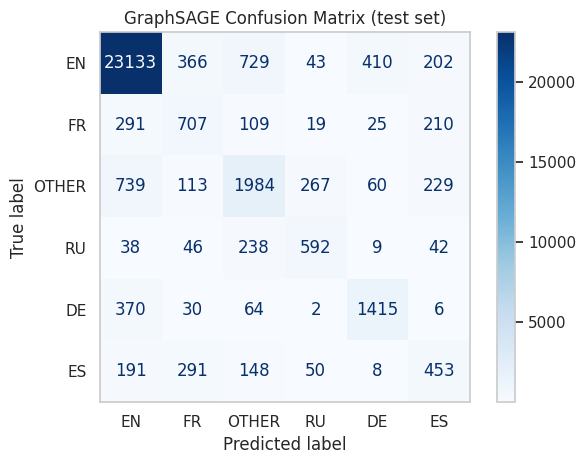

In [ ]:
print("\n---------------GraphSAGE MODEL (Validation)---------------\n")
graphsage_val_accuracy = evaluate_graphsage(data=data_b, model=gs_B, mask_type="val", class_labels=['EN', 'FR', 'OTHER', 'RU', 'DE', 'ES'])

print("\n---------------GraphSAGE MODEL (Test)---------------\n")
graphsage_test_accuracy = evaluate_graphsage(data=data_b, model=gs_B, mask_type="test", class_labels=['EN', 'FR', 'OTHER', 'RU', 'DE', 'ES'])

Regression

In [ ]:
# Instead of creating binary 'high_views', keep continuous views
target_col = "views_log"
drop_cols = ["high_views", "updated_at", "life_time", "numeric_id",
             "language", "language_label", "language_target", "created_at", "created_at_log"]

features_task_reg = features_df.drop(columns=drop_cols).astype(np.float32)

# Store original views separately
original_views = torch.tensor(features_df["views"].values, dtype=torch.float32).view(-1, 1)

# Convert to tensors
y_task_reg = torch.tensor(features_task_reg[target_col].values, dtype=torch.float32).view(-1, 1)
x_task_reg = torch.tensor(features_task_reg.drop(columns=[target_col, "views"]).values, dtype=torch.float32)

# Create PyG Data object with original views as additional attribute
data_reg = Data(x=x_task_reg, y=y_task_reg, edge_index=edge_index, original_views=original_views)

In [ ]:
# Splitting and Masking

num_nodes = data_reg.num_nodes
indices = torch.randperm(num_nodes)

# Calculate split indices
train_end = int(0.6 * num_nodes)  # 60% for training
val_end = train_end + int(0.2 * num_nodes)  # 20% for validation

# Create masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign indices to masks
train_mask[indices[:train_end]] = True
val_mask[indices[train_end:val_end]] = True
test_mask[indices[val_end:]] = True

# Assign masks to data object
data_reg.train_mask = train_mask
data_reg.val_mask = val_mask
data_reg.test_mask = test_mask

In [ ]:
#Feature scaling for GNN Regression task
dummy_indices = [0, 1, 2] + list(range(5, data_a.x.size(1)))  # dummies: first 3 + all language columns (assuming lang_* start at col 5)
numerical_indices = [3, 4]  # updated_at_log, life_time_log at columns 3 and 4    # mature, dead_account, affiliate


x = data_reg.x.detach().cpu().numpy()
train_mask = data_reg.train_mask.detach().cpu().numpy()

x_dummy = x[:, dummy_indices]
x_num = x[:, numerical_indices]

scaler = StandardScaler()
scaler.fit(x_num[train_mask])
x_num_scaled = scaler.transform(x_num)
x_scaled = np.hstack([x_dummy, x_num_scaled])
data_reg.x = torch.FloatTensor(x_scaled).to(device)

In [ ]:
class GNNRegression(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.linear = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, data.edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        return self.linear(x)

# Initialize GNN
gnn_regression = GNNRegression(input_dim=x_task_reg.shape[1]).to(device)

In [ ]:
def train_gnn_reg(model, data, epochs=500, lr=0.005, weight_decay=0.0005, patience=25):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    early_stopper = EarlyStopping(patience=patience, min_delta=0.0001, path='gnn_regressor_checkpoint.pt')

    train_losses = []
    val_losses = []

    data = data.to(device)
    model = model.to(device)

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            val_output = model(data)
            val_loss = criterion(val_output[data.val_mask], data.y[data.val_mask]).item()
            val_losses.append(val_loss)

        print(f'Epoch {epoch+1:03d}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

        # Early stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(torch.load(early_stopper.path))
    print(f"Loaded best model weights from {early_stopper.path}")

    # Plot losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('GNN Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    return model, train_losses, val_losses

Epoch 001, Train Loss: 73.3003, Val Loss: 72.9963
Validation loss decreased (72.996315 --> 72.996315). Saving model...
Epoch 002, Train Loss: 72.8472, Val Loss: 72.5708
Validation loss decreased (72.996315 --> 72.570816). Saving model...
Epoch 003, Train Loss: 72.4254, Val Loss: 72.1485
Validation loss decreased (72.570816 --> 72.148460). Saving model...
Epoch 004, Train Loss: 71.9985, Val Loss: 71.7121
Validation loss decreased (72.148460 --> 71.712120). Saving model...
Epoch 005, Train Loss: 71.5640, Val Loss: 71.2546
Validation loss decreased (71.712120 --> 71.254608). Saving model...
Epoch 006, Train Loss: 71.1202, Val Loss: 70.7627
Validation loss decreased (71.254608 --> 70.762688). Saving model...
Epoch 007, Train Loss: 70.6366, Val Loss: 70.2314
Validation loss decreased (70.762688 --> 70.231445). Saving model...
Epoch 008, Train Loss: 70.0968, Val Loss: 69.6563
Validation loss decreased (70.231445 --> 69.656303). Saving model...
Epoch 009, Train Loss: 69.5364, Val Loss: 69.032

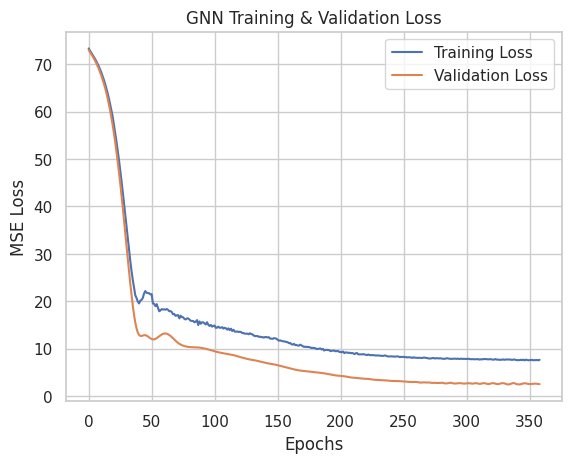

In [ ]:
# Train GNN
gnn_regression, gnn_train_losses, gnn_val_losses = train_gnn_reg(gnn_regression, data_reg)

In [ ]:
def evaluate_gnn_regression(model, data, mask_type='test'):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        mask = data.val_mask if mask_type == 'val' else data.test_mask
        log_preds = model(data).squeeze()[mask].cpu()
        log_true = data.y[mask].cpu().squeeze()
        original_true = data.original_views[mask].cpu().squeeze()  # Get original views

    # Transform predictions back to original scale
    preds_original = torch.exp(torch.clamp(log_preds, min=-10, max=10))

    # Calculate metrics
    metrics = {
        'log_scale': {
            'mse': F.mse_loss(log_preds, log_true).item(),
            'mae': F.l1_loss(log_preds, log_true).item(),
            'r2': r2_score(log_true.numpy(), log_preds.numpy())
        },
        'original_scale': {
            'mse': F.mse_loss(preds_original, original_true).item(),
            'mae': F.l1_loss(preds_original, original_true).item(),
            'r2': r2_score(original_true.numpy(), preds_original.numpy())
        }
    }

    # Print results
    print(f"\nEvaluation on {mask_type} set:")
    print("Log scale metrics:")
    print(f"MSE: {metrics['log_scale']['mse']:.4f}, MAE: {metrics['log_scale']['mae']:.4f}, R²: {metrics['log_scale']['r2']:.4f}")
    print("Original scale metrics (direct comparison with true views):")
    print(f"MSE: {metrics['original_scale']['mse']:.4f}, MAE: {metrics['original_scale']['mae']:.4f}, R²: {metrics['original_scale']['r2']:.4f}")

    return metrics

In [ ]:
# Evaluate GNN
gnn_val_metrics = evaluate_gnn_regression(gnn_regression, data_reg, 'val')
gnn_test_metrics = evaluate_gnn_regression(gnn_regression, data_reg, 'test')


Evaluation on val set:
Log scale metrics:
MSE: 2.4771, MAE: 1.2022, R²: 0.4082
Original scale metrics (direct comparison with true views):
MSE: 4983094771712.0000, MAE: 163858.3750, R²: -0.0043

Evaluation on test set:
Log scale metrics:
MSE: 2.4431, MAE: 1.1993, R²: 0.4154
Original scale metrics (direct comparison with true views):
MSE: 10752440139776.0000, MAE: 191146.3281, R²: -0.0028


In [ ]:
x_mlp = features_task_reg.drop(columns=[target_col]).values
y_mlp = features_task_reg[target_col].values.reshape(-1, 1)

# Convert to tensors
x_mlp = torch.FloatTensor(x_mlp)
y_mlp = torch.FloatTensor(y_mlp)

# Split data
train_size = int(0.6 * len(x_mlp))
val_size = int(0.2 * len(x_mlp))
test_size = len(x_mlp) - train_size - val_size

train_dataset_reg, val_dataset_reg, test_dataset_reg = random_split(
    TensorDataset(x_mlp, y_mlp),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


In [ ]:
# Feature processing for Task B
X_train = train_dataset_reg[:][0].numpy()
X_val = val_dataset_reg[:][0].numpy()
X_test = test_dataset_reg[:][0].numpy()

X_train_num, X_train_dummy = split_features(X_train, numerical_indices, dummy_indices)
X_val_num, X_val_dummy = split_features(X_val, numerical_indices, dummy_indices)
X_test_num, X_test_dummy = split_features(X_test, numerical_indices, dummy_indices)

scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_val_num_scaled = scaler.transform(X_val_num)
X_test_num_scaled = scaler.transform(X_test_num)

total_features = X_train.shape[1]
X_train_scaled = combine_features(X_train_num_scaled, X_train_dummy, numerical_indices, dummy_indices, total_features)
X_val_scaled = combine_features(X_val_num_scaled, X_val_dummy, numerical_indices, dummy_indices, total_features)
X_test_scaled = combine_features(X_test_num_scaled, X_test_dummy, numerical_indices, dummy_indices, total_features)

y_train = train_dataset_reg[:][1]
y_val = val_dataset_reg[:][1]
y_test = test_dataset_reg[:][1]

X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

train_dataset_reg = TensorDataset(X_train_tensor, y_train)
val_dataset_reg = TensorDataset(X_val_tensor, y_val)
test_dataset_reg = TensorDataset(X_test_tensor, y_test)

In [ ]:
# MLP Model
class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize MLP
mlp_regression = MLPRegression(input_dim=x_mlp.shape[1]).to(device)
summary(mlp_regression, input_size=(x_mlp.shape[1],))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           7,168
         LeakyReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
         LeakyReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
         LeakyReLU-8                   [-1, 64]               0
            Linear-9                    [-1, 1]              65
Total params: 48,385
Trainable params: 48,385
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.18
Estimated Total Size (MB): 0.19
---------------------------------------------

In [ ]:
def train_mlp(model, train_loader, val_loader, epochs=500, lr=0.001, weight_decay=0.001, patience=25):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    early_stopper = EarlyStopping(patience=patience, min_delta=0.0001, path='mlp_regressor_best.pth')

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_loss += criterion(model(X_val), y_val).item()

        # Store losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1:03d}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping
        early_stopper(avg_val_loss, model)
        if early_stopper.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    model.load_state_dict(torch.load(early_stopper.path))
    print(f"Best model loaded from {early_stopper.path}")

    # Plot losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

    return model, train_losses, val_losses

Epoch 001, Train Loss: 45675860.6872, Val Loss: 3833.9991
Validation loss decreased (3833.999136 --> 3833.999136). Saving model...
Epoch 002, Train Loss: 17868.4064, Val Loss: 1238.2553
Validation loss decreased (3833.999136 --> 1238.255340). Saving model...
Epoch 003, Train Loss: 2093.5520, Val Loss: 317.4053
Validation loss decreased (1238.255340 --> 317.405279). Saving model...
Epoch 004, Train Loss: 2069.7548, Val Loss: 4540.4899
Epoch 005, Train Loss: 3031.2264, Val Loss: 382.4566
Epoch 006, Train Loss: 2554.6019, Val Loss: 26.2899
Validation loss decreased (317.405279 --> 26.289935). Saving model...
Epoch 007, Train Loss: 557.1886, Val Loss: 10.5009
Validation loss decreased (26.289935 --> 10.500883). Saving model...
Epoch 008, Train Loss: 707.1829, Val Loss: 59.7007
Epoch 009, Train Loss: 2196.3837, Val Loss: 10.5252
Epoch 010, Train Loss: 543.0059, Val Loss: 5.8581
Validation loss decreased (10.500883 --> 5.858107). Saving model...
Epoch 011, Train Loss: 1009.6821, Val Loss: 40

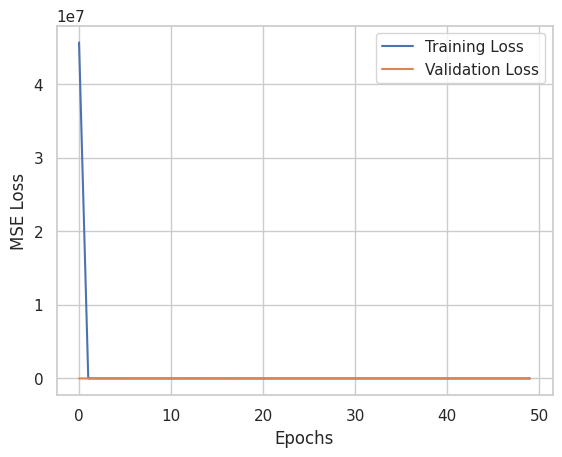

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset_reg, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_reg, batch_size=batch_size)
test_loader = DataLoader(test_dataset_reg, batch_size=batch_size)

# Train MLP
mlp_regressor, mlp_train_losses, mlp_val_losses = train_mlp(
    mlp_regression, train_loader, val_loader
)

In [ ]:
def evaluate_mlp(model, loader, original_views_test):
    model.eval()
    device = next(model.parameters()).device

    all_log_preds = []
    all_log_true = []
    all_original_true = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            log_preds = model(X).squeeze()
            all_log_preds.append(log_preds.cpu())
            all_log_true.append(y.cpu())

    log_preds = torch.cat(all_log_preds)
    log_true = torch.cat(all_log_true).squeeze()
    original_true = original_views_test  # This should be the test portion of original views

    # Transform predictions back to original scale
    preds_original = torch.exp(torch.clamp(log_preds, min=-10, max=10))

    # Calculate metrics
    metrics = {
        'log_scale': {
            'mse': F.mse_loss(log_preds, log_true).item(),
            'mae': F.l1_loss(log_preds, log_true).item(),
            'r2': r2_score(log_true.numpy(), log_preds.numpy())
        },
        'original_scale': {
            'mse': F.mse_loss(preds_original, original_true).item(),
            'mae': F.l1_loss(preds_original, original_true).item(),
            'r2': r2_score(original_true.numpy(), preds_original.numpy())
        }
    }

    print("\nMLP Evaluation:")
    print("Log scale metrics:")
    print(f"MSE: {metrics['log_scale']['mse']:.4f}, MAE: {metrics['log_scale']['mae']:.4f}, R²: {metrics['log_scale']['r2']:.4f}")
    print("Original scale metrics (direct comparison with true views):")
    print(f"MSE: {metrics['original_scale']['mse']:.4f}, MAE: {metrics['original_scale']['mae']:.4f}, R²: {metrics['original_scale']['r2']:.4f}")

    return metrics

In [ ]:
# Evaluate MLP
def inverse_transform(log_views):
    """Convert log-transformed views back to original scale"""
    original = torch.exp(log_views) -1e-6
    return torch.clamp(original, min=0)  # Ensure no negative values

# After your random_split:
_, y_val = val_dataset_reg[:]  # Get log-transformed validation targets
_, y_test = test_dataset_reg[:]  # Get log-transformed test targets

# Convert back to original scale (properly handling the small constant)
original_views_val = inverse_transform(y_val.squeeze())
original_views_test = inverse_transform(y_test.squeeze())


original_views

# Evaluate MLP
mlp_val_metrics = evaluate_mlp(mlp_regressor, val_loader, original_views_val)
mlp_test_metrics = evaluate_mlp(mlp_regressor, test_loader, original_views_test)


MLP Evaluation:
Log scale metrics:
MSE: 1.7028, MAE: 0.7021, R²: 0.5857
Original scale metrics (direct comparison with true views):
MSE: 12469558837248.0000, MAE: 190054.8750, R²: -0.0028

MLP Evaluation:
Log scale metrics:
MSE: 1.7021, MAE: 0.7050, R²: 0.5895
Original scale metrics (direct comparison with true views):
MSE: 8481557446656.0000, MAE: 162104.0312, R²: -0.0030
